In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# 1. Prepare TS Data

In [3]:
# Time Series 생성
filepath = os.getenv('HOME') + '/aiffel/Time Series/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(filepath, parse_dates=True)


df = df.set_index('Date')
print(df.head())

ts = df['Close']
ts.head()
print(ts)
print(type(ts))

print(type(ts))

               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2020-05-18  47950.0  49100.0  47600.0  48800.0  46788.835938  20481981
2020-05-19  50100.0  50500.0  49700.0  50300.0  48227.015625  25168295
2020-05-20  50000.0  50200.0  49800.0  50000.0  47939.382813  14896899
2020-05-21  50300.0  50400.0  49850.0  49950.0  47891.437500  14949266
2020-05-22  49600.0  49800.0  48600.0  48750.0  46740.894531  19706284
Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
               ...   
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, Length: 250, dtype: float64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


# 2. Pre Processing

In [4]:
ts = ts.interpolate('linear')

ts[ts.isna()]

Series([], Name: Close, dtype: float64)

<AxesSubplot:xlabel='Date'>

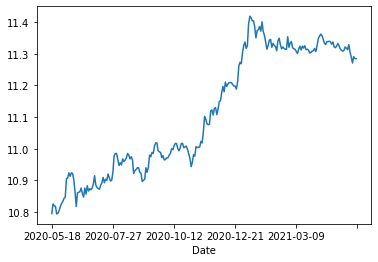

In [6]:
ts_log = np.log(ts)

ts_log.plot()

# 3. Stationary Analysis

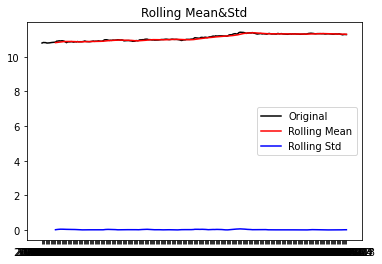

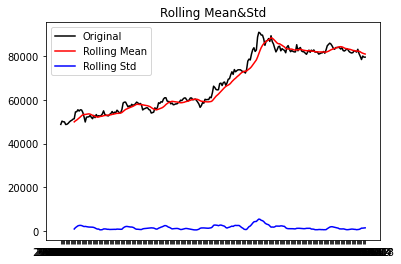

In [8]:
# Visual Analysis

def plot_rolling_stats(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    original = plt.plot(timeseries, c='k', label='Original')
    r_mean = plt.plot(rolmean, c='r', label='Rolling Mean')
    r_std = plt.plot(rolstd, c='b', label='Rolling Std')

    plt.legend(loc='best')
    plt.title('Rolling Mean&Std')
    plt.show();
    
plot_rolling_stats(ts_log)
plot_rolling_stats(ts)

In [9]:
# ADF Test

from statsmodels.tsa.stattools import adfuller

def adf(timeseries):
    
    test = adfuller(timeseries, autolag = 'AIC')
    print('Result of ADF')
    
    output = pd.Series(test[:4], index = ['Test Stat', 'p-value', '#Lag', '#Observs'])
    
    for key, value in test[4].items():
        output['Critical Value (%s)' % key] = value
        
    print(output)
    
adf(ts_log)

Result of ADF
Test Stat                -1.383525
p-value                   0.590149
#Lag                      0.000000
#Observs                249.000000
Critical Value (1%)      -3.456888
Critical Value (5%)      -2.873219
Critical Value (10%)     -2.572994
dtype: float64


Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64
0.0


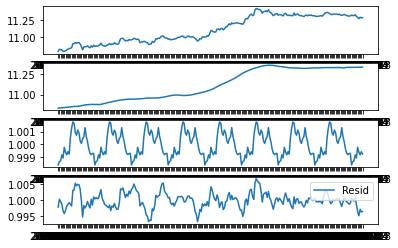

In [17]:
# TS Decomp

from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(ts_log, model='multiplicative', period=30, extrapolate_trend='freq')

print(ts_log)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

print(residual.isna().mean())

# fillNA for residuals
resid_fillna = residual.fillna(0)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.subplot(414)
plt.plot(residual, label='Resid')
plt.legend(loc='best')

In [18]:
adf(residual)

Result of ADF
Test Stat              -6.404646e+00
p-value                 1.956861e-08
#Lag                    9.000000e+00
#Observs                2.400000e+02
Critical Value (1%)    -3.457894e+00
Critical Value (5%)    -2.873659e+00
Critical Value (10%)   -2.573229e+00
dtype: float64


In [19]:
residual.dropna(inplace=True)
adf(residual)

Result of ADF
Test Stat              -6.404646e+00
p-value                 1.956861e-08
#Lag                    9.000000e+00
#Observs                2.400000e+02
Critical Value (1%)    -3.457894e+00
Critical Value (5%)    -2.873659e+00
Critical Value (10%)   -2.573229e+00
dtype: float64


# 4. Train, Test Split

In [120]:
train, test = ts_log[:int(len(ts_log)*0.8)], ts_log[int(len(ts_log)*0.8):]
print(ts_log.shape)
print(train.shape, test.shape, train)

(250,)
(200,) (50,) Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-03-02    11.333799
2021-03-03    11.338572
2021-03-04    11.319341
2021-03-05    11.315693
2021-03-08    11.314475
Name: Close, Length: 200, dtype: float64


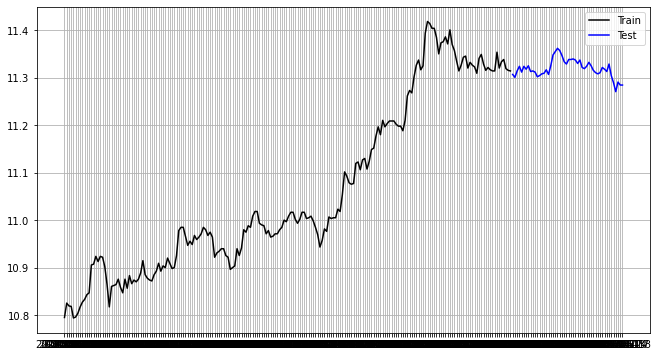

In [121]:
# visualize
plt.grid(True)
plt.plot(train, c='k', label='Train')
plt.plot(test, c='b', label='Test')
plt.legend()

# 5. Finding ARIMA p, d, q

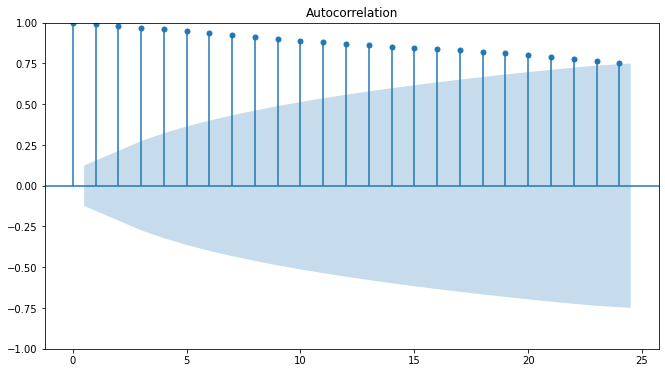

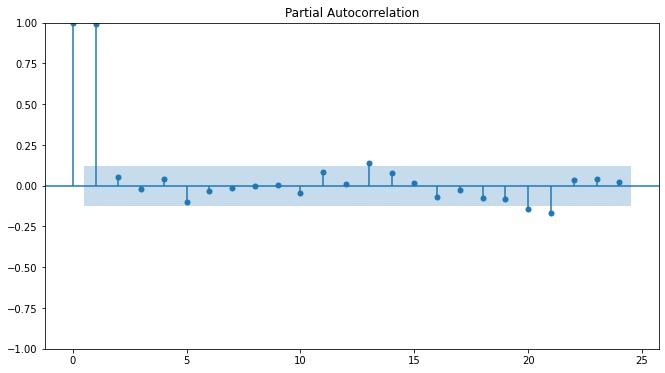

In [122]:
# ACF, PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show();

<AxesSubplot:xlabel='Date'>

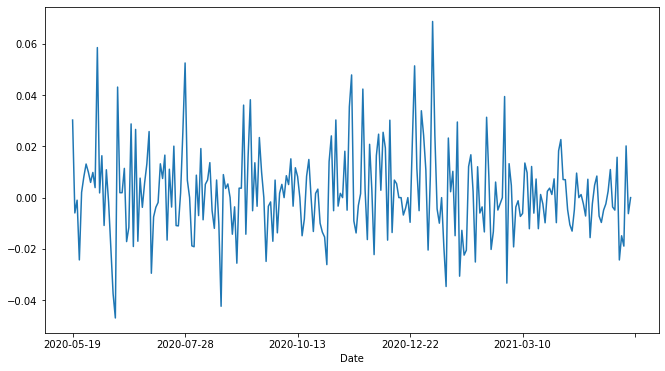

In [123]:
diff1 = ts_log.diff()[1:]
diff1.plot()

In [124]:
adf(diff1)

Result of ADF
Test Stat              -1.553699e+01
p-value                 2.183738e-28
#Lag                    0.000000e+00
#Observs                2.480000e+02
Critical Value (1%)    -3.456996e+00
Critical Value (5%)    -2.873266e+00
Critical Value (10%)   -2.573019e+00
dtype: float64


# 6. ARIMA train & test

In [134]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(2, 0, 1))
fitted = model.fit()

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  200
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 510.090
Date:                Thu, 29 Feb 2024   AIC                          -1010.179
Time:                        08:58:36   BIC                           -993.688
Sample:                             0   HQIC                         -1003.506
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0604      0.142     77.663      0.000      10.781      11.340
ar.L1          0.6478      1.803      0.359      0.719      -2.885       4.181
ar.L2          0.3453      1.794      0.193      0.8

In [135]:
fitted = fitted.predict()[1:]
print(fitted)

Date
2020-05-19    10.796762
2020-05-20    10.828051
2020-05-21    10.820310
2020-05-22    10.820188
2020-05-25    10.794781
                ...    
2021-03-02    11.317446
2021-03-03    11.333644
2021-03-04    11.336915
2021-03-05    11.317448
2021-03-08    11.314530
Name: predicted_mean, Length: 199, dtype: float64


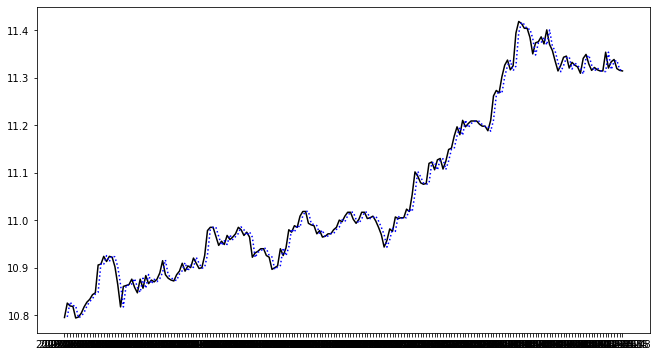

In [136]:
plt.plot(train, c='k')
plt.plot(fitted, c='b', ls=':')

In [128]:
# forecast

model = ARIMA(train, order=(2, 0, 1))
fitted = model.fit()
fc = fitted.forecast(len(test), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test.index)

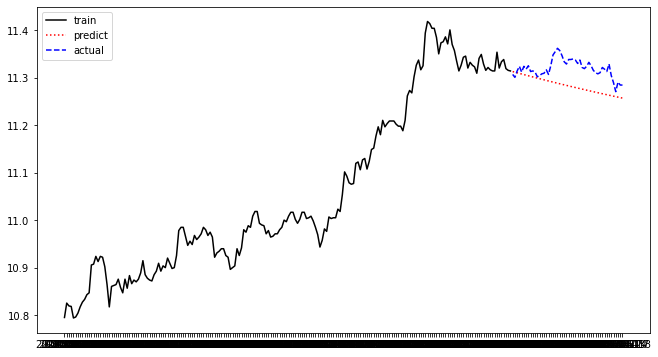

In [129]:
plt.plot(train, c='k', label='train')
plt.plot(fc_series, c='r', ls=':', label='predict')
plt.plot(test, c='b', ls='--', label='actual')
plt.legend(loc='best')
plt.show();

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_absolute_error(np.exp(test), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test)) / np.abs(np.exp(test)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  11481312.386692274
MAE:  2920.6840973811545
RMSE:  54.04335386873352
MAPE: 3.52%


# BTC Price

In [77]:
filepath2 = os.getenv('HOME')+'/aiffel/Time Series/stock_prediction/data/BTC-USD.csv' 

btc = pd.read_csv(filepath2, index_col = 'Date', parse_dates = True)
btc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-28,23521.837891,23585.384766,23077.650391,23147.353516,23147.353516,20535363434
2023-03-01,23150.929688,23880.632813,23088.626953,23646.550781,23646.550781,24662841200
2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,23475.466797,20386398516
2023-03-03,23476.632813,23479.347656,22213.238281,22362.679688,22362.679688,26062404610
2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,22353.349609,11166012913


In [81]:
ts2 = btc['Close']
ts2.head()

Date
2023-02-28    23147.353516
2023-03-01    23646.550781
2023-03-02    23475.466797
2023-03-03    22362.679688
2023-03-04    22353.349609
Name: Close, dtype: float64

<AxesSubplot:xlabel='Date'>

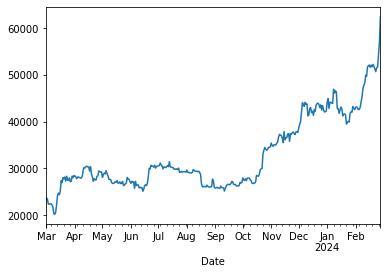

In [83]:
ts2.plot()

In [84]:
ts2[ts2.isna()]

Series([], Name: Close, dtype: float64)

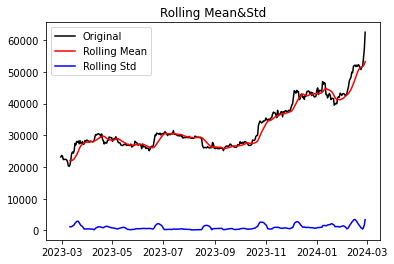

In [85]:
plot_rolling_stats(ts2)

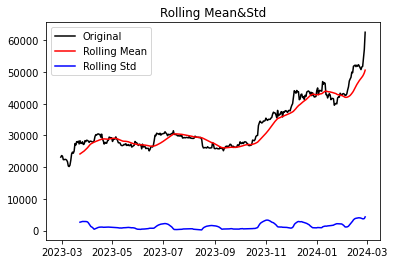

In [86]:
plot_rolling_stats(ts2, window=24)

In [87]:
adf(ts2)

Result of ADF
Test Stat                 1.831411
p-value                   0.998409
#Lag                      2.000000
#Observs                363.000000
Critical Value (1%)      -3.448494
Critical Value (5%)      -2.869535
Critical Value (10%)     -2.571029
dtype: float64


In [88]:
ts2_log = np.log(ts2)
adf(ts2_log)

Result of ADF
Test Stat                 0.590899
p-value                   0.987389
#Lag                      2.000000
#Observs                363.000000
Critical Value (1%)      -3.448494
Critical Value (5%)      -2.869535
Critical Value (10%)     -2.571029
dtype: float64


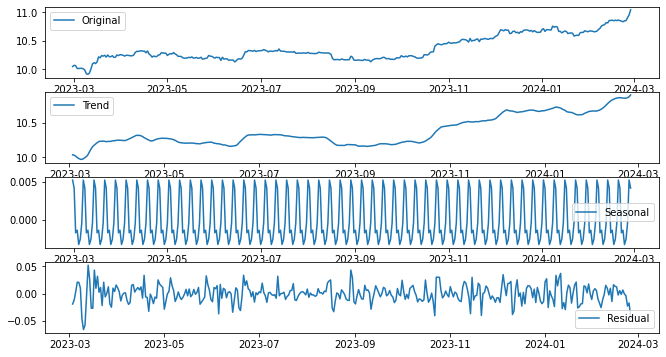

In [89]:
# decomp

decomp = seasonal_decompose(ts2_log)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.rcParams['figure.figsize'] = (11, 6)

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')


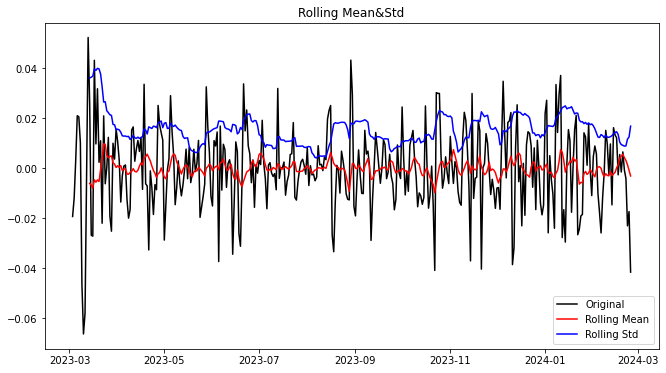

In [90]:
plot_rolling_stats(residual)

In [92]:
resid_nona = residual.dropna()

In [93]:
adf(resid_nona)

Result of ADF
Test Stat              -8.915880e+00
p-value                 1.073094e-14
#Lag                    1.500000e+01
#Observs                3.440000e+02
Critical Value (1%)    -3.449503e+00
Critical Value (5%)    -2.869979e+00
Critical Value (10%)   -2.571266e+00
dtype: float64


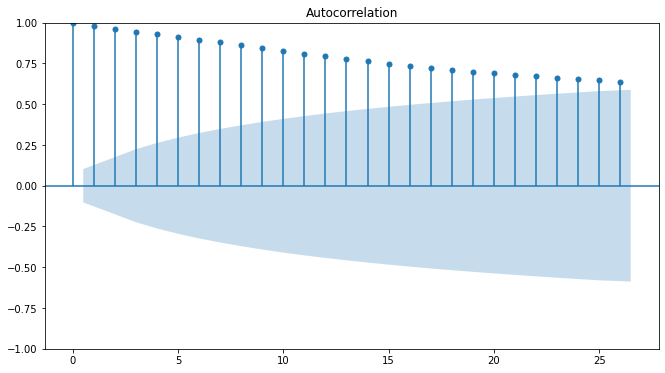

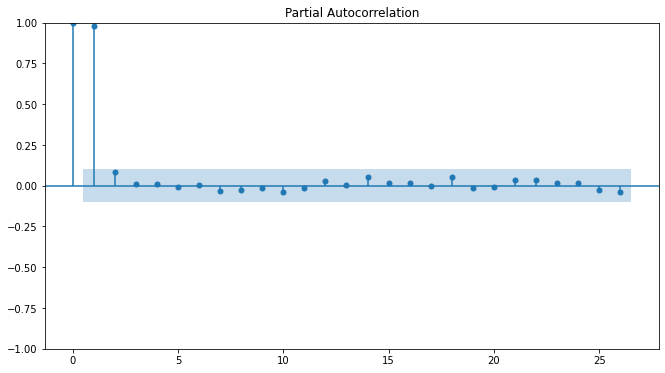

In [95]:
plot_acf(ts2_log)
plot_pacf(ts2_log)
plt.show();

<AxesSubplot:xlabel='Date'>

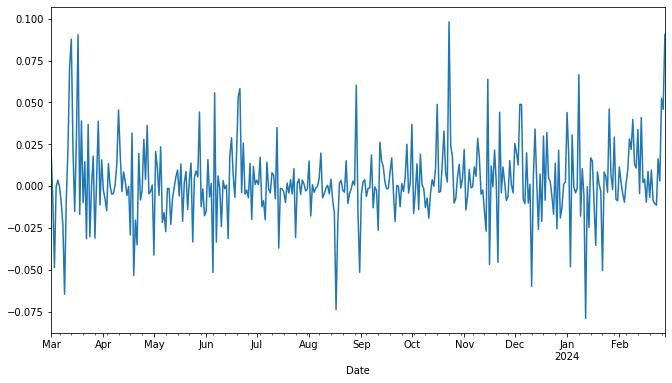

In [96]:
diff_1 = ts2_log.diff(1)[1:]
diff_1.plot()

In [97]:
adf(diff_1)

Result of ADF
Test Stat              -1.157504e+01
p-value                 3.037008e-21
#Lag                    1.000000e+00
#Observs                3.630000e+02
Critical Value (1%)    -3.448494e+00
Critical Value (5%)    -2.869535e+00
Critical Value (10%)   -2.571029e+00
dtype: float64


In [98]:
adf(ts2_log)

Result of ADF
Test Stat                 0.590899
p-value                   0.987389
#Lag                      2.000000
#Observs                363.000000
Critical Value (1%)      -3.448494
Critical Value (5%)      -2.869535
Critical Value (10%)     -2.571029
dtype: float64


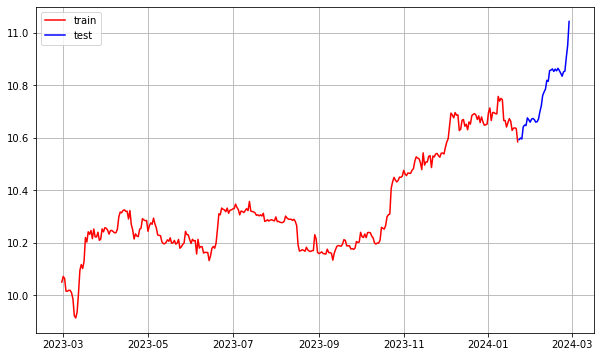

In [100]:
# train test split

train, test = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(train, c='r', label='train')
plt.plot(test, c='b', label='test')
plt.legend(loc='best')

In [101]:
print(train.shape, '\n', test.shape)

(329,) 
 (37,)


In [102]:
ts2_log.head()

Date
2023-02-28    10.049636
2023-03-01    10.070973
2023-03-02    10.063711
2023-03-03    10.015149
2023-03-04    10.014731
Name: Close, dtype: float64

In [103]:
!pip install pmdarima

In [107]:
from pmdarima import auto_arima

model = auto_arima(train, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1534.380, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1540.991, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1539.094, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1539.083, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1541.342, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1537.130, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.844 seconds


In [108]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  329
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 771.671
Date:                Thu, 29 Feb 2024   AIC                          -1541.342
Time:                        08:29:48   BIC                          -1537.549
Sample:                             0   HQIC                         -1539.828
                                - 329                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   2.61e-05     20.263      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               126.18
Prob(Q):                              0.75   Pr

In [110]:
fc = model.predict(len(test))
fc

array([10.58424244, 10.58424244, 10.58424244, 10.58424244, 10.58424244,
       10.58424244, 10.58424244, 10.58424244, 10.58424244, 10.58424244,
       10.58424244, 10.58424244, 10.58424244, 10.58424244, 10.58424244,
       10.58424244, 10.58424244, 10.58424244, 10.58424244, 10.58424244,
       10.58424244, 10.58424244, 10.58424244, 10.58424244, 10.58424244,
       10.58424244, 10.58424244, 10.58424244, 10.58424244, 10.58424244,
       10.58424244, 10.58424244, 10.58424244, 10.58424244, 10.58424244,
       10.58424244, 10.58424244])

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original')
plt.plot(pd.date_range(ts.index[-1], periods=6, closed='right'), forecasts, label='Forecast')  # Adjust date range as needed
plt.legend()
plt.show()